# **Internet Domain Price Prediction Model**

This report explores the pricing of internet domains first by using natural language processing techniques to extract features from internet domain names, then by performing exploratory data analytics on the extracted features to identify trends and inconsistencies. The extracted features are thereafter passed into a model that predicts the prices of new domain names using multiple machine learning algorithms. The outcome is a model which predicts with an accuracy score of 99.86%.

In this paper, the dataset used is provided by SmartPredict, a data analytics company which specializes in predictions problems. As of November 24, 2022, the dataset contains 10,000 domains divided into 5 categories i.e., 1, 2, 3, 4, and 5 respectively

## **Importing Libraries and Data**


In [ ]:
# Importing the relevant libraries

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import collections
from scipy.stats import entropy
import nltk
from nltk.corpus import words, stopwords
nltk.download('words')
nltk.download('stopwords')
!pip install langid
from langid.langid import LanguageIdentifier, model
import gensim.downloader as api
!pip install wordninja
import wordninja
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/coursework_data.csv')
data.head()

Mounted at /content/drive


,Domain,category
0,noriomatsumoto.com,1
1,haplessmales.com,1
2,shivamchatuvedi.com,1
3,dailyfreebieoffer.com,1
4,poniemall.com,1


In [ ]:
dist = data.category.value_counts().to_frame().reset_index()
dist['% distribution'] = data.category.value_counts().values/data.shape[0] * 100
dist.columns = ['categories', 'count', '% distribution']
dist

,categories,count,% distribution
0,1,6000,60.0
1,2,2000,20.0
2,3,1000,10.0
3,4,500,5.0
4,5,500,5.0


There appears to be an imbalance in the data

## **Feature Extraction**

Features are extracted from the domain name feature such as the Shannon entropy, language score, and character ratios in the domain name. These features are carefully curated to extract as much meaningful information from the domain name as possible.

Shannon Entropy for example, is used to quantify the unpredictability of characters in the domain name. It is used to determine the level of uncertainty associated with a specific character following another in a textual string. In essence, a high Shannon entropy makes sense in relation to the length of the string in question as a string with high variability and high length is likely gibberish. Same applies where the string has low variability.

Language score is also calculated to classify the domain names to different languages. A high English language score implies that the domain name is recognized as English. This is useful assuming that domain names in English have more value.

Wordninja library is used to extract all meaningful words (if any) from the domain name. From this feature, it is evident that the maximum number of meaningful words in each domain name is 8 while only 17 domain names had 5 or more meaningful words.

A pre-trained “word2vec-google-news-300” api was also used to generate 1X300 array vectors which value the domain string relative to the scoring of its meaningful words according to google.

**Extracted Features**

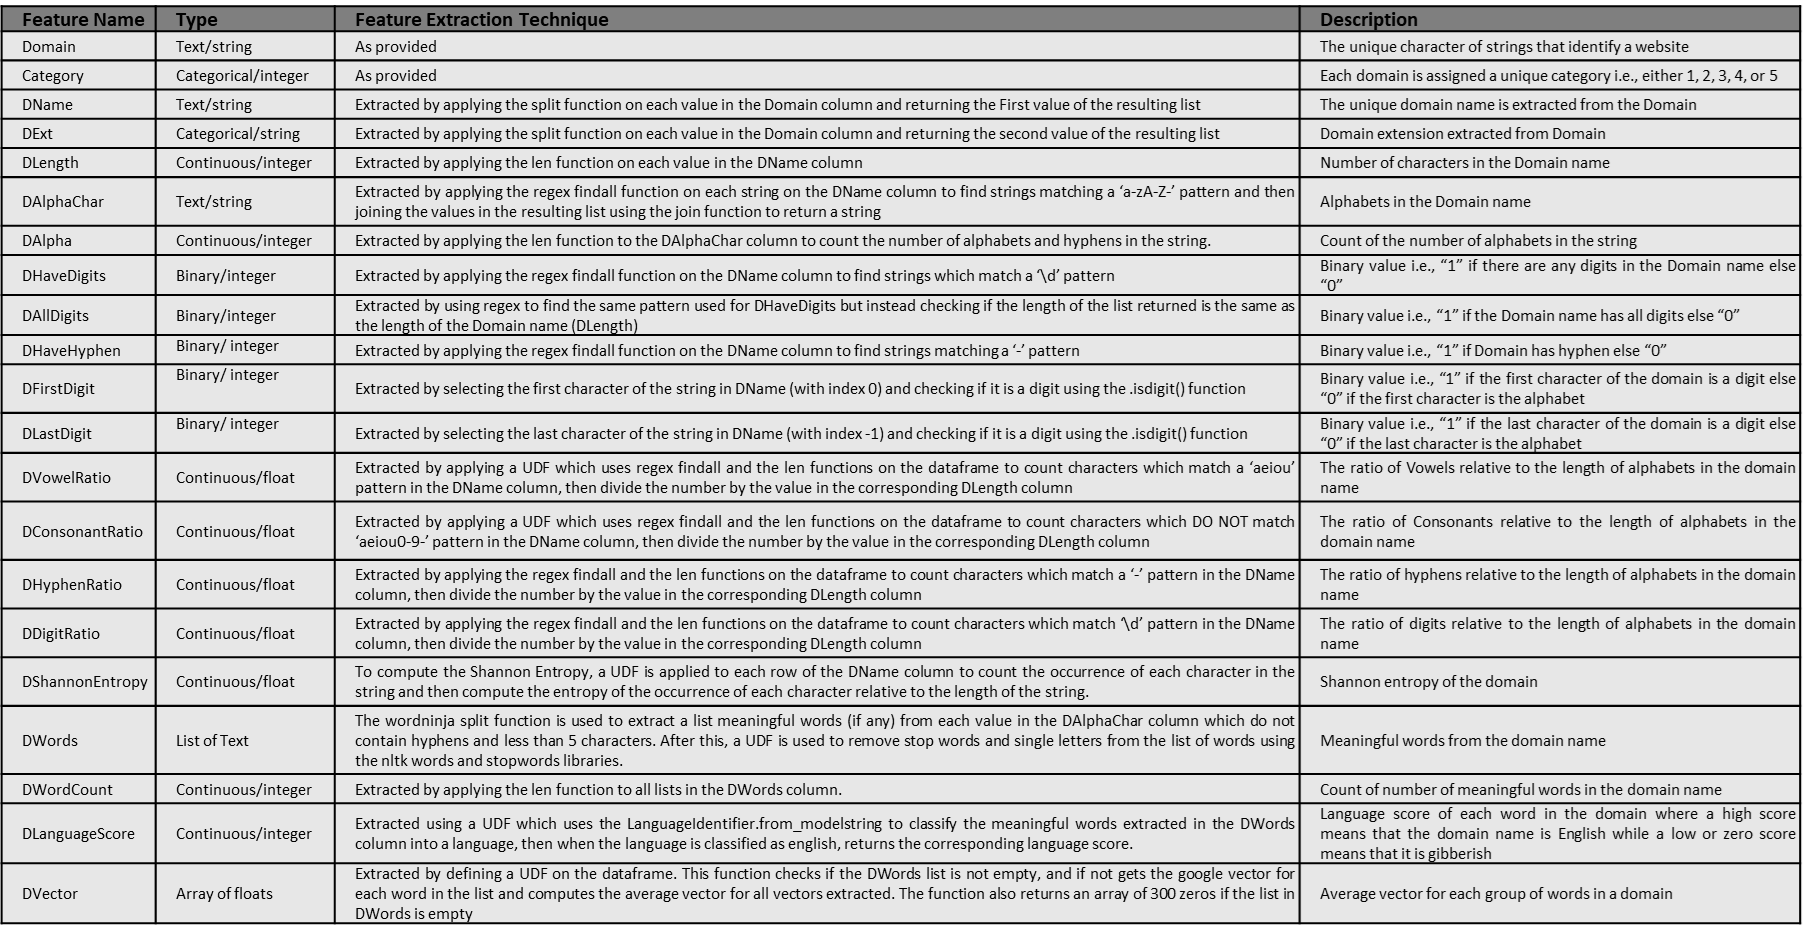

In [ ]:
# Extracting the domain name
data['DName'] = data['Domain'].apply(lambda x: x.split('.')[0].lower())

# Extracting the domain extension
data['DExt'] = data['Domain'].apply(lambda x: x.split('.')[1])

# Counting the number of characters in the domain name
data['DLength'] = data['DName'].apply(lambda x: len(x))

# Extracting all alphabets in the domain name and counting the number of alphabets in the string
data['DAlphaChar'] = data['DName'].apply(lambda x: ''.join(re.findall('[a-zA-Z-]', x)))
data['DAlpha'] = data['DAlphaChar'].apply(lambda x: len(x))

# Are there digits in the domain name
data['DHaveDigits'] = data['DName'].apply(lambda x: 0 if len(re.findall('\d', x)) == 0 else 1)
data['DAllDigits'] = data.apply(lambda x: 1 if len(re.findall('\d', x['DName'])) == x['DLength'] else 0, axis = 1)

# Are there hyphens in the domain name
data['DHaveHyphen'] = data['DName'].apply(lambda x: 0 if len(re.findall('[-]', x)) == 0 else 1)

# Checking if the first character of the domain name is an alphabet or digit: 1 if digit, 0 if alphabet
data['DFirstDigit'] = data['DName'].apply(lambda x: 1 if x[0].isdigit() else 0)

# Checking if the last character of the domain name is an alphabet or digit: 1 if digit, 0 if alphabet
data['DLastDigit'] = data['DName'].apply(lambda x: 1 if x[-1].isdigit() else 0)

# Define UDF to compute the ratio of vowels and consonants relative to the length of alphabets in the domain name
def extract_ratio(x, arg):
  if x['DAlpha'] == 0:
    return 0
  elif arg == 'vowel':
    return len(re.findall('[aeiou]', x['DName']))/x['DLength']
  elif arg == 'cons':
    return len(re.findall('[^aeiou0-9-]', x['DName']))/x['DLength']

# Compute the ratio of vowels to total alphabets (reflects pronouncability)
data['DVowelRatio'] = data.apply(lambda x: extract_ratio(x, 'vowel'), axis = 1)

# Compute the ratio of consonants to total alphabets
data['DConsonantRatio'] = data.apply(lambda x: extract_ratio(x, 'cons'), axis = 1)

# Compute the ratio of underscore
data['DHyphenRatio'] = data.apply(lambda x: len(re.findall('[-]', x['DName']))/x['DLength'], axis = 1)

# Compute the ratio of underscore
data['DDigitRatio'] = data.apply(lambda x: len(re.findall('\d', x['DName']))/x['DLength'], axis = 1)

In [ ]:
# define a UDF which computes the shannon entropy of any given string
def shannon_entropy(d_name):
    # count occurence of each character in the string
    xters = collections.Counter([txt for txt in d_name])
    # compute the ratio of each character relative to the length of the string
    dist = [x/sum(xters.values()) for x in xters.values()]
    # compute the entropy
    shan_entropy = entropy(dist, base=2)

    return shan_entropy

data['DShannonEntropy'] = data['DName'].apply(lambda x: shannon_entropy(x))

In [ ]:
# extract all meaningful words from the domain name if any using the wordninja library
data['DWords'] = data['DAlphaChar'].apply(lambda x: x.split('-') if '-' in x and len(x) > 5 else wordninja.split(x))

# define a function to remove stopwords and single letters from a list of words
def clean_LOW(lst):
  # list of english stop words
  stops = list(set(stopwords.words('english')))
  # list of english alphabets
  alphabets = [chr(x) for x in range(ord('a'), ord('z') + 1)]
  # set of stopwords in list of words
  stops_in_lst = set(lst).intersection(set(stops))
  # set of alphabets in list of words
  remove = set(lst).intersection(set(alphabets).union(set(stops)))
  for i in remove:
    if i in lst:
      lst.remove(i)
  for i in lst:
    if len(i) <= 2:
      lst.remove(i)
  return lst

data['DWords'] = data['DWords'].apply(lambda x: clean_LOW(x))
# count number of meaningful words in the domain name
data['DWordCount'] = data['DWords'].apply(lambda x: len(x))
data['DWordCount'].max()

8

In [ ]:
cnt = data[data['DWordCount'] > 5].shape[0]
print('There are %d domain names in the dataset with 5 or more meaningful words' %cnt)

There are 17 domain names in the dataset with 5 or more meaningful words


In [ ]:
# Define a function that identified the domain names and classifies them to different languages. This may be considered the language score of the domain name i.e. a
# high language score means that the domain name is recognizable as english while a low score or score of zero means the domain name is gibberish
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

# define a function that identifies each word in the string and computes a language score where the language is english
def lang_score(x):
  score = 0
  if len(x) == 0:
    pass
  else:
    for i in x:
      lang_and_score = identifier.classify(i)
      if lang_and_score[0] == 'en':
        score =+ lang_and_score[1]
    score = score/len(x)
  return score

data['DLanguageScore'] = data['DWords'].apply(lambda x: lang_score(x))

In [ ]:
# Loading in the pre-trained google word 2 vec
from gensim.models import KeyedVectors
file_path = "/content/drive/MyDrive/GoogleNews-vectors-negative300.bin"

# Load into gensim
wv = KeyedVectors.load_word2vec_format(file_path, binary=True)

In [ ]:
# # Loading in the pre-trained google word 2 vec
# wv = api.load('word2vec-google-news-300')

# define function to obtain the average vector for each group of words
def vectorize(x):
  vec = np.zeros(300)
  if x['DWords'] == []:
    pass
  else:
    for i in x['DWords']:
      try:
        vec =+ wv[i]
      except:
        pass
    vec = vec/x['DWordCount']
  return vec

data['DVector'] = data.apply(lambda x: vectorize(x), axis = 1)

## **Data Exploration**

Some data analysis is done to identify trends in the OG and extracted features.

Text(0.5, 1.0, 'Distribution of Price Rankings of the domain names')

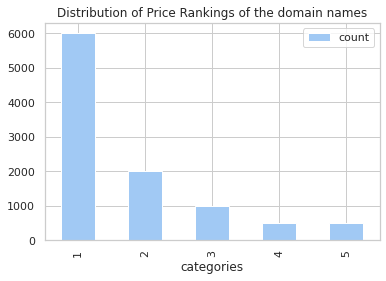

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
dist.plot('categories', 'count', kind = 'bar')
plt.title('Distribution of Price Rankings of the domain names')

There is an evident imbalance in the target variable distribution as 60% of the domain names are classified into a single category. Very few domain names in the dataset have high value. This can be expected in real world scenarios but may also be indicative of the poor quality of data provided for the purpose of this study. An imbalanced dataset can subsequently result in the predictive algorithms overfitting on the overpopulated category.

[Determining Domain Value](https://www.ionos.co.uk/digitalguide/domains/domain-tips/determining-domain-value/#:~:text=Characters%2C%20digits%2C%20or%20words%20that%20are%20part%20of,possible%20web%20projects%20also%20have%20a%20value-reducing%20effect.) highlights how certain factors such as domain length and character combinations can influence the value of a domain. These features are explored to further understand the type of data we are working with.

Text(0.5, 1.0, 'Boxplot of Domain Name Lengths')

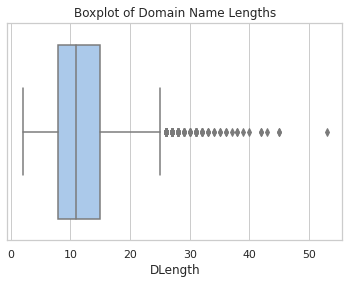

In [ ]:
sns.boxplot(data['DLength'])
plt.title('Boxplot of Domain Name Lengths')

It appears there are a number of outliers in the domain name length feature. Domain names with more than 25 characters appear sparingly but can introduce noise to the predictive algorithm we intend to train. Also, as the value of domain names tend to decrease as the character length increases, odds are these outliers likely belong to lower valued category increasing the chances of our model overfitting on these categories.

A quick and easy bivariate analysis is also done to explore trends in the character features of the domain names relative to the target categories they are assigned.

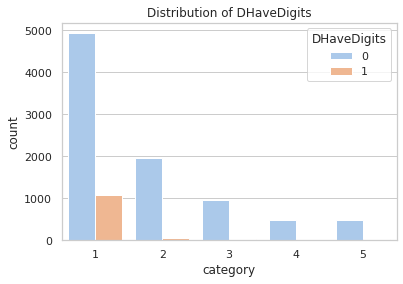

0    88.1
1    11.9
Name: DHaveDigits, dtype: float64


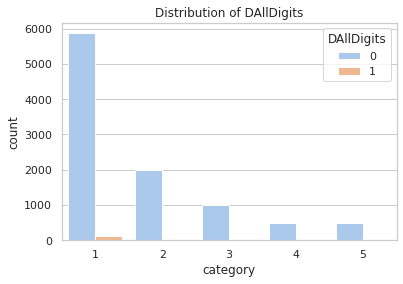

0    98.58
1     1.42
Name: DAllDigits, dtype: float64


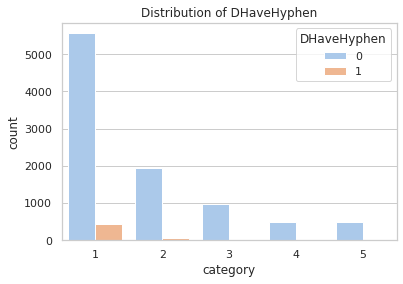

0    94.8
1     5.2
Name: DHaveHyphen, dtype: float64


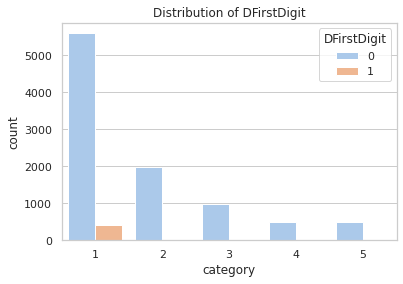

0    95.48
1     4.52
Name: DFirstDigit, dtype: float64


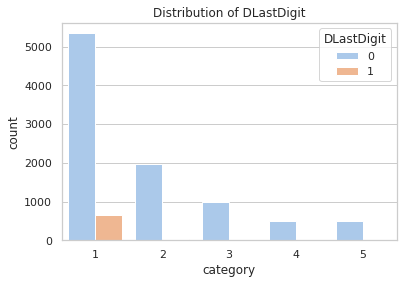

0    92.79
1     7.21
Name: DLastDigit, dtype: float64


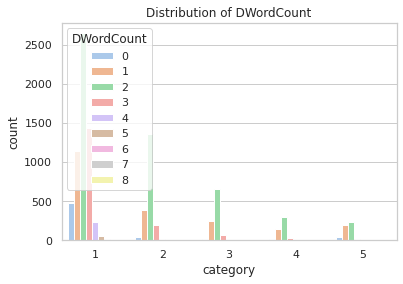

2    51.99
1    21.14
3    17.60
0     5.98
4     2.55
5     0.57
6     0.15
8     0.01
7     0.01
Name: DWordCount, dtype: float64


In [ ]:
binary = ['DHaveDigits', 'DAllDigits', 'DHaveHyphen', 'DFirstDigit', 'DLastDigit', 'DWordCount']
for i in binary:
  sns.countplot(data = data, x = 'category', hue = i)
  plt.title('Distribution of %s' %i)
  plt.show()
  print(data[i].value_counts()/data.shape[0]*100)

Most of the features trend similarly with the general distribution of domain names across the target variable categories. Noteably, the word count feature shows a visible trend of domain names with higher value having increasing less meaningful words in them i.e., 2 words or less for categories 3, 4, and 5.

Text(0.5, 1.0, 'Distribution of Word counts across the respective categories')

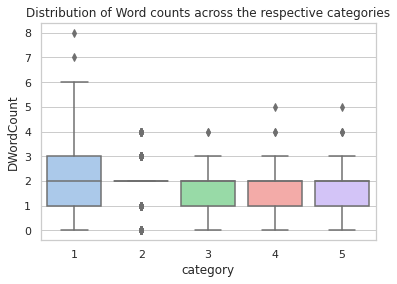

In [ ]:
sns.boxplot(data=data, x='category', y='DWordCount')
plt.title('Distribution of Word counts across the respective categories')

Text(0.5, 1.0, 'Distribution of Domain Name Lengths across the respective categories')

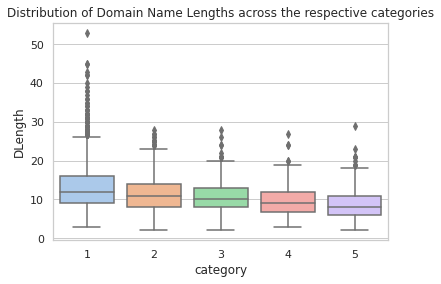

In [ ]:
sns.boxplot(data=data, x='category', y='DLength')
plt.title('Distribution of Domain Name Lengths across the respective categories')

A closer look at the outlier distribution for each category further highlights our earlier observation that outliers in the domain length feature are likely to belong to lower valued categories. The same is observed for the word count feature as well.

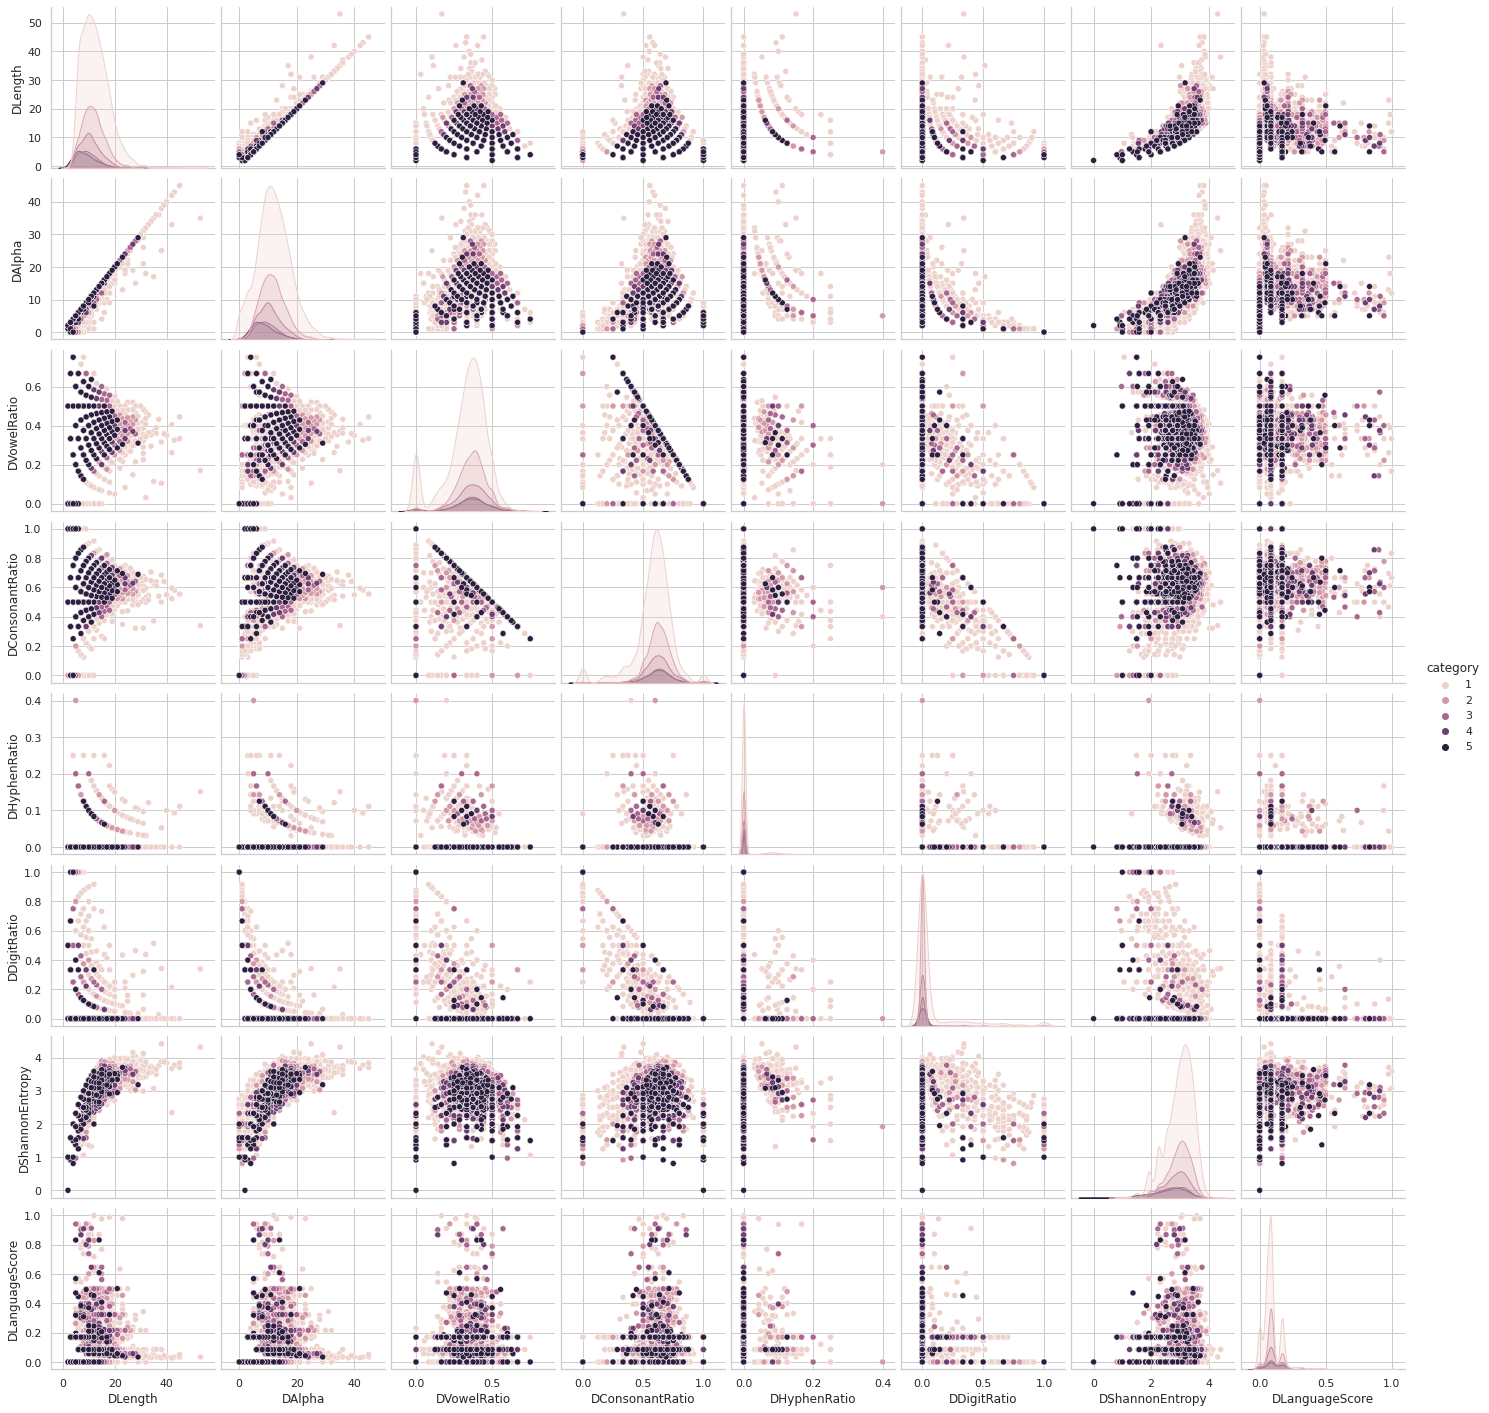

In [ ]:
sns.pairplot(data = data, vars = ['DLength', 'DAlpha', 'DVowelRatio', 'DConsonantRatio', 'DHyphenRatio', 'DDigitRatio', 'DShannonEntropy', 'DLanguageScore'], hue = 'category')

From the above, we can see a strong relationship between the number of alphabets in our domain names and the total number of characters (row 1, column 2) showing that most of the domain names contain more alphabets than other character types (digits & hyphens). However, domain names in category 1 stand out as the DLength value increases beyond 30 and can also be seen to have a lower alphabet to length ratio than the other categories.

We also see a strong similarity between the trends in Dlength and DAlpha features (rows 1 & 2 respectively), as well as the DVowelRatio & DConsonantRatio (rows 3 & 4 respectively) albeit somewhat inverted. This is rather intuitive as these variables are interdependent i.e., the presence of the former implies the presence or absence of the latter.

From row 3, column 4, we see that the higher valued domain names tend to show a direct correlation between the vowel ratio and consonant ratio whereas the lower domain names show more variability. This implies that higher valued domain names have a more balanced mix of vowels and consonants i.e. are less likely to be gibberish.

From rows 5 and 6, it is evident that higher valued domain names tend to have less digits and hyphens in them.

The shannon entropy of the domain names tend to vary evenly across the target categories but can be seen to be highest in a handful of domain names with lower value. It is also interesting to see how this variable trends upwards where domain names are longer but plateaus around the Dlength value of 15. This highlights the limitation of the shannon entropy concept as appears to provide less information about the degree of variability in longer textual strings.



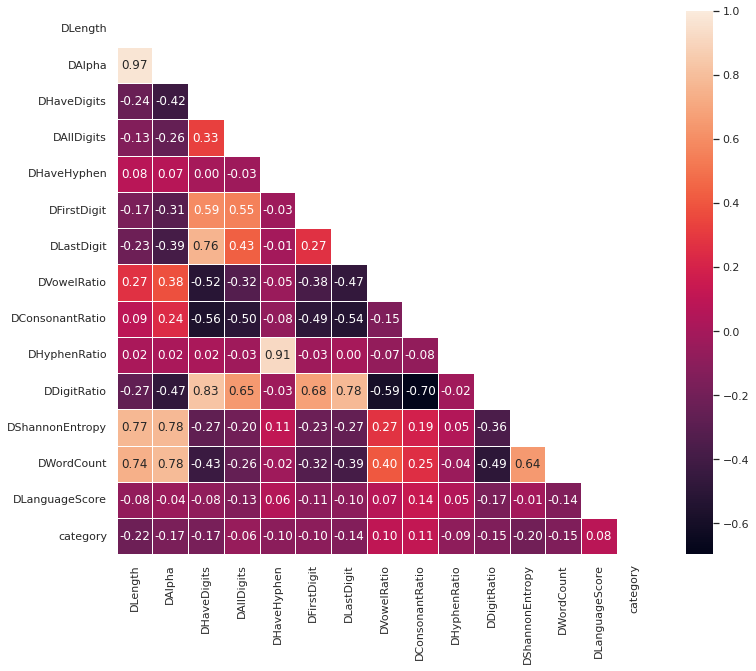

In [ ]:
corr = continuous_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask, vmax=1, annot=True, fmt='.2f', square=False, linewidths=.5, cbar = True);

*   The above chart shows the correlation between the extracted numerical features in the dataset. As observed previously, there is a high correlation between the length of the domain names and the number of alphabets in the domain name.
*   There is also a high correlation between the shannon entropy of a textual string and the length of the string, although this has already been observed as a limitation considering the shannon entropy peaks when the length of the string is greater than or equal to 15.
*   The word count feature also correlates highly with the length of the string as higher string lengths intuitively imply more meaningful words can be extracted from the string.
*   Strong correlations are also observed in features that extract similar information from the domain names such as the hyphen features - DHyphenRation and DHaveHyphen, and digit features - DDigitRatio, DAllDigits, DHaveDigits, DFirstDigit and DLastDigit.

## **Data Cleaning**

Data must be cleaned in preparation for machine learning. This includes treating outliers, checking validity of data, treating null values, et al. Two variables i.e., “DAlpha” and “DHyphenRatio” were identified to have high correlation to other variables (greater than +0.9 or less than -0.9) and were dropped as they will only introduce noise to the model and increase complexity. Missing data or null values were also checked.  

[Domain Name Rules](https://www.dynadot.com/community/blog/domain-name-rules.html#:~:text=Domain%20names%20are%20only%20allowed%20to%20be%2063,referred%20to%20as%20the%20%E2%80%98label%E2%80%99%20between%20the%20two.) list a few requirements that all internet domain names must satisfy to be accepted as legitimate, such as having the correct domain extension, having 63 or fewer characters, being able to contain numbers, but only being allowed to use hyphen '-' as special characters. These guidelines were used to determine whether the submitted domain names are legitimate. From our checks, all domain names have the same extension ‘.com’ which is correct, length of the domain name are all less than 63 characters and the only special characters in the domain names are hyphens. Domain names with more than 25 characters were however dropped as they are the outliers.

In [ ]:
# Identifying columns with high correlation (+ or - 0.9) with other columns as they will only introduce noise to the model
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.9)]
to_drop

['DAlpha', 'DHyphenRatio']

In [ ]:
# dropping the columns
clean_data = data.drop(to_drop, axis = 1)

In [ ]:
# Drop null values if any
print('We have %s rows before dropping null values' % clean_data.shape[0])
clean_data.dropna(subset = ['DName'], inplace = True)
print('We have %s rows after dropping null values' % clean_data.shape[0])

We have 10000 rows before dropping null values
We have 10000 rows after dropping null values


In [ ]:
clean_data.isnull().sum()

Domain             0
category           0
DName              0
DExt               0
DLength            0
DAlphaChar         0
DHaveDigits        0
DAllDigits         0
DHaveHyphen        0
DFirstDigit        0
DLastDigit         0
DVowelRatio        0
DConsonantRatio    0
DDigitRatio        0
DShannonEntropy    0
DWords             0
DWordCount         0
DLanguageScore     0
DVector            0
dtype: int64

There are no null values in the dataset. According to [Domain Name Rules](https://www.dynadot.com/community/blog/domain-name-rules.html#:~:text=Domain%20names%20are%20only%20allowed%20to%20be%2063,referred%20to%20as%20the%20%E2%80%98label%E2%80%99%29%20between%20the%20two.), we were also able to identify some criteria that all internet domain names must meet to be considered valid e.g. the correct domain extension, the length of characters must be 63 or less, domain names can contain numbers but the only permitted special character is the hyphen '-'. We will check validity of the domain names provided against these rules

**Step 2**: Check validity of domain (domain extension)

In [ ]:
clean_data['DExt'].value_counts()

com    10000
Name: DExt, dtype: int64

All domain extensions are valid. All our domains have the same extension '.com' so we will drop this column to reduce the noise in the data

In [ ]:
clean_data.drop(['DExt'], axis = 1, inplace = True)

**Step 3**: Check the length of the domain name to ensure it is less than 63 characters

In [ ]:
clean_data[clean_data['DLength'] > 63].shape[0]
# There are no domain names with lengths greater than 63

0

In [ ]:
# also dropping the outliers identified in the DLength column i.e. domain names with more than 25 characters
clean_data = clean_data[clean_data['DLength'] <= 25]

In [ ]:
 # Number of special characters
 sc = clean_data['DName'].apply(lambda x: len(re.findall('[\W]', x))).sum()
 # Number of hyphens
 hp = clean_data['DName'].apply(lambda x: len(re.findall('[-]', x))).sum()
 # Number of special characters excluding hyphens
 sc - hp

0

In [ ]:
clean_data.head()

,Domain,category,DName,DLength,DAlphaChar,DHaveDigits,DAllDigits,DHaveHyphen,DFirstDigit,DLastDigit,DVowelRatio,DConsonantRatio,DDigitRatio,DShannonEntropy,DWords,DWordCount,DLanguageScore,DVector
0,noriomatsumoto.com,1,noriomatsumoto,14,noriomatsumoto,0,0,0,0,0,0.500000,0.500000,0.0,2.950212,"[norio, matsumoto]",2,0.084731,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,haplessmales.com,1,haplessmales,12,haplessmales,0,0,0,0,0,0.333333,0.666667,0.0,2.688722,"[hapless, males]",2,0.084731,"[-0.0014038086, 0.06298828, -0.08642578, -0.05..."
2,shivamchatuvedi.com,1,shivamchatuvedi,15,shivamchatuvedi,0,0,0,0,0,0.400000,0.600000,0.0,3.373557,"[shiva, chat, edi]",3,0.056487,"[0.004313151, 0.041341145, -0.06673177, 0.0011..."
3,dailyfreebieoffer.com,1,dailyfreebieoffer,17,dailyfreebieoffer,0,0,0,0,0,0.470588,0.529412,0.0,3.101881,"[daily, freebie, offer]",3,0.056487,"[-0.087890625, -0.009399414, -0.032552082, 0.0..."
4,poniemall.com,1,poniemall,9,poniemall,0,0,0,0,0,0.444444,0.555556,0.0,2.947703,[poni],1,0.169462,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
clean_data = clean_data[clean_data['DWordCount'] != 0]

## **Feature Selection**

In [ ]:
# decomposing the word vectors from 300 to 15
pca = PCA(n_components = 15)
outcome = pca.fit_transform(pd.DataFrame(np.vstack(clean_data['DVector'].values)))
pca_df = pd.DataFrame(data = outcome, columns = ['DPCA1', 'DPCA2', 'DPCA3', 'DPCA4', 'DPCA5', 'DPCA6', 'DPCA7', 'DPCA8', 'DPCA9', 'DPCA10', 'DPCA11', 'DPCA12', 'DPCA13',
                                                 'DPCA14', 'DPCA15'])

In [ ]:
pca_df.shape

(9267, 15)

In [ ]:
clean_data.shape

(9267, 18)

In [ ]:
# concatinating the data with the pca columns
all_data = clean_data.reset_index().join(pca_df)
# dropping the original vector column
all_data.drop(['DVector'], inplace = True, axis = 1)

In [ ]:
# splitting the data into dependent and independent variables
y = all_data[['category']]
# also dropping text features
X = all_data.drop(['category', 'Domain', 'DName', 'DAlphaChar', 'DWords'], axis = 1)

In [ ]:
# define a function to measure the variance of our data features
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold):
  selector = VarianceThreshold(threshold)
  selector.fit(data)
  return data[data.columns[selector.get_support(indices=True)]]

filtered_X = variance_threshold_selector(X, threshold=0.02)

## **Model Building**

In [ ]:
# splitting the dataset
train_x, val_x, train_y, val_y = train_test_split(filtered_X, y, test_size = 0.3, random_state = 0, stratify = y)
train_x.shape, val_x.shape

((6486, 22), (2781, 22))

In [ ]:
# scaling the data using a minmaxscaler as we have some negative values in our PCA features
scaler = MMS(feature_range=(0, 1))
scaled_train_x = scaler.fit_transform(train_x)
scaled_val_x = scaler.transform(val_x)

### **Logistic Regression**

The precision using Logisitic Regression before hyperparameter tuning is 0.8649244917590326
The recall using Logisitic Regression before hyperparameter tuning is 0.8881697231211795
The accuracy score using Logisitic Regression before hyperparameter tuning is 0.8881697231211795
The F1 score using Logisitic Regression before hyperparameter tuning is 0.8713558931561315 



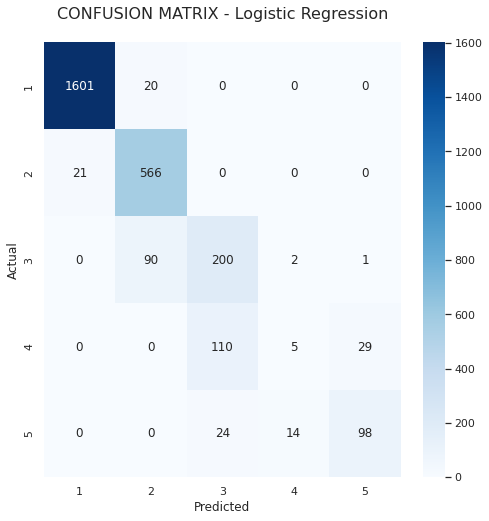

In [ ]:
lr = LR()
lr.fit(scaled_train_x, train_y)
pred_y = lr.predict(scaled_val_x)
print('The precision using Logisitic Regression before hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Logisitic Regression before hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Logisitic Regression before hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Logisitic Regression before hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size = 16);

### **Support Vector Machines**

The precision using Support Vector Machine before hyperparameter tuning is 0.9552171699161002
The recall using Support Vector Machine before hyperparameter tuning is 0.9557713052858684
The accuracy score using Support Vector Machine before hyperparameter tuning is 0.9557713052858684
The F1 score using Support Vector Machine before hyperparameter tuning is 0.9553548649459969 



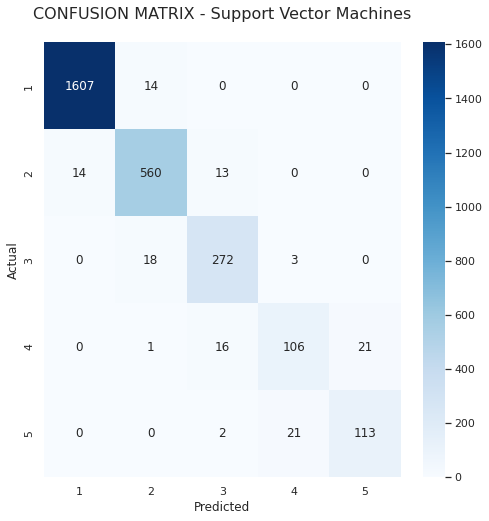

In [ ]:
svc = SVC()
svc.fit(scaled_train_x, train_y)
pred_y = svc.predict(scaled_val_x)
print('The precision using Support Vector Machine before hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Support Vector Machine before hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Support Vector Machine before hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Support Vector Machine before hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Support Vector Machines\n", size = 16);

### **Decision Trees**

The precision using Decision Trees before hyperparameter tuning is 0.9985724062682684
The recall using Decision Trees before hyperparameter tuning is 0.998561668464581
The accuracy score using Decision Trees before hyperparameter tuning is 0.998561668464581
The F1 score using Decision Trees before hyperparameter tuning is 0.9985627856420672 



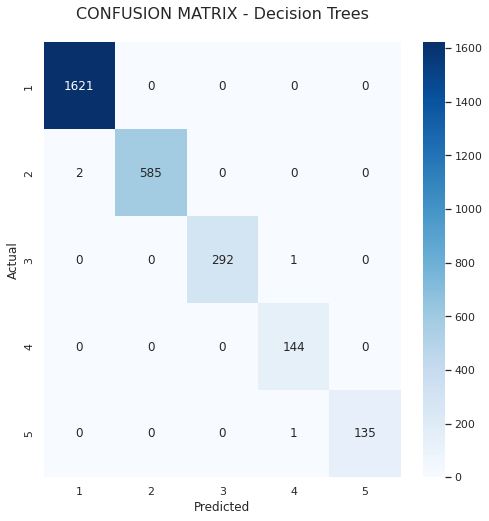

In [ ]:
dtc = DTC()
dtc.fit(scaled_train_x, train_y)
pred_y = dtc.predict(scaled_val_x)
print('The precision using Decision Trees before hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Decision Trees before hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Decision Trees before hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Decision Trees before hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
confusion_matrix(val_y, pred_y)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Decision Trees\n", size = 16);

## **Using Smote to Address Data Imbalance**

In [ ]:
# Rebalancing the dataset to evenly distribute the target variable
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler(random_state = 0)
ros = RandomOverSampler(random_state = 0)
X_undersampled, y_undersampled = rus.fit_resample(scaled_train_x, train_y)
X_oversampled, y_oversampled = ros.fit_resample(scaled_train_x, train_y)
y_undersampled.mean(), y_oversampled.mean(), train_y.mean()

(category    3.0
 dtype: float64, category    3.0
 dtype: float64, category    1.772895
 dtype: float64)

The precision using Support Vector Machine before hyperparameter tuning is 0.9062857729829056
The recall using Support Vector Machine before hyperparameter tuning is 0.8946422150305645
The accuracy score using Support Vector Machine before hyperparameter tuning is 0.8946422150305645
The F1 score using Support Vector Machine before hyperparameter tuning is 0.8983797165903719 



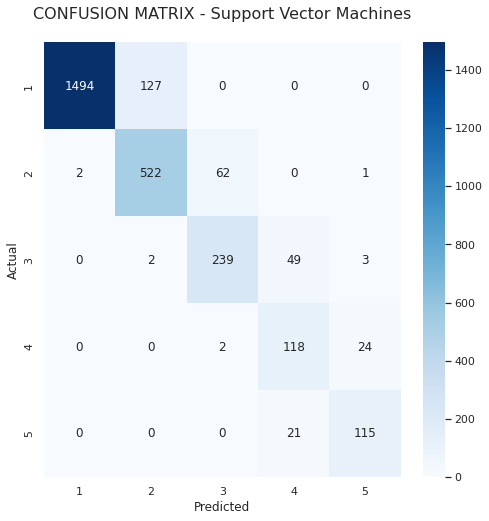

In [ ]:
svc.fit(X_undersampled, y_undersampled)
pred_y = svc.predict(scaled_val_x)
print('The precision using Support Vector Machine before hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Support Vector Machine before hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Support Vector Machine before hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Support Vector Machine before hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Support Vector Machines\n", size = 16);

The precision using Support Vector Machine before hyperparameter tuning is 0.9522488814793766
The recall using Support Vector Machine before hyperparameter tuning is 0.949658396260338
The accuracy score using Support Vector Machine before hyperparameter tuning is 0.949658396260338
The F1 score using Support Vector Machine before hyperparameter tuning is 0.950502244311166 



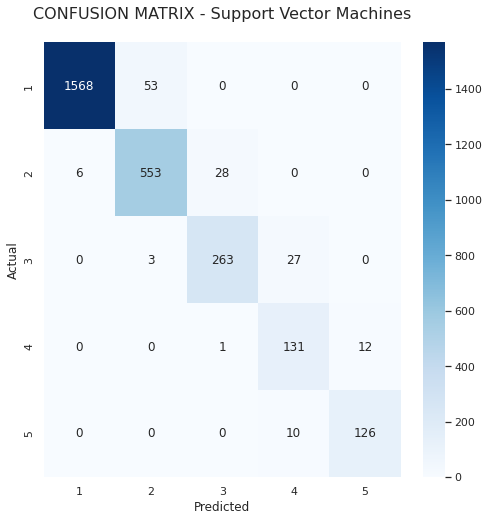

In [ ]:
svc.fit(X_oversampled, y_oversampled)
pred_y = svc.predict(scaled_val_x)
print('The precision using Support Vector Machine before hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Support Vector Machine before hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Support Vector Machine before hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Support Vector Machine before hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Support Vector Machines\n", size = 16);

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# ann = Sequential()
# ann.add(Dense(units=64, activation='relu'))
# ann.add(Dense(units=32, activation='relu'))
# ann.add(Dropout(0.5))

# # output layer
# ann.add(Dense(units=1, activation='softmax'))

# #Compiling the ANN
# ann.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])
# #Fitting ANN
# ann.fit(X_undersampled, y_undersampled, batch_size=32, epochs = 100)

## **Hyperparameter Tuning**

In [ ]:
lr_param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'random_state': [0], 'C':[1, 10, 20, 50]}
svc_param_grid = {'kernel': ('linear', 'rbf'), 'C':[1, 10, 20, 50]}
dtc_param_grid = {'criterion': ['gini', 'entropy'], 'splitter':['best', 'random'], 'max_depth': [i for i in range (1, 11, 2)]}

In [ ]:
lr_gs = GridSearchCV(lr, lr_param_grid, cv = 4)
lr_gs.fit(X_oversampled, y_oversampled)
lr_gs.best_params_

{'C': 1, 'penalty': 'l1', 'random_state': 0, 'solver': 'saga'}

In [ ]:
svc_gs = GridSearchCV(svc, svc_param_grid, cv = 4)
svc_gs.fit(X_undersampled, y_undersampled)
svc_gs.best_params_

{'C': 50, 'kernel': 'linear'}

In [ ]:
dtc_gs = GridSearchCV(dtc, dtc_param_grid, cv = 4)
dtc_gs.fit(scaled_train_x, train_y)
dtc_gs.best_params_

{'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}

## **Final Results**

The precision using Logisitic Regression after hyperparameter tuning is 0.9726690559067719
The recall using Logisitic Regression after hyperparameter tuning is 0.9715929521754765
The accuracy score using Logisitic Regression after hyperparameter tuning is 0.9715929521754765
The F1 score using Logisitic Regression after hyperparameter tuning is 0.9718944953974091 



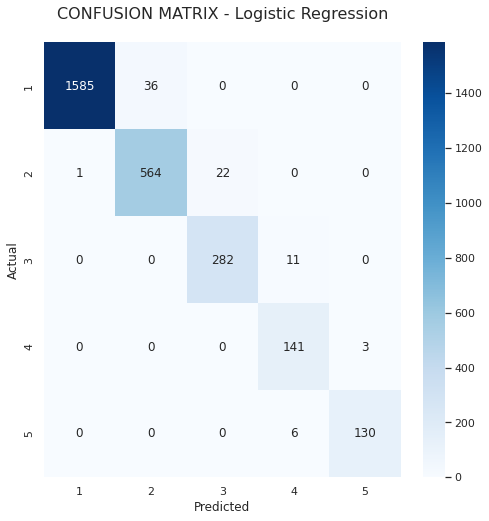

In [ ]:
lr = LR(C = 1, penalty = 'l1', random_state = 0, solver = 'saga')
lr.fit(X_oversampled, y_oversampled)
pred_y = lr.predict(scaled_val_x)
print('The precision using Logisitic Regression after hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Logisitic Regression after hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Logisitic Regression after hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Logisitic Regression after hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size = 16);

The Logistic Regression intercept value is 112.82540972886825 



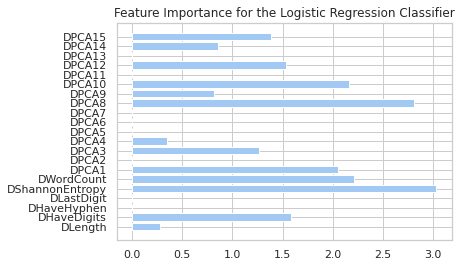

In [ ]:
print('The Logistic Regression intercept value is', lr.intercept_[0], '\n')
plt.barh(train_x.columns[1:], lr.coef_[0][1:], align='center')
plt.title('Feature Importance for the Logistic Regression Classifier')
plt.show()

The precision using Support Vector Machine after hyperparameter tuning is 0.9614454917248604
The recall using Support Vector Machine after hyperparameter tuning is 0.9593671341244157
The accuracy score using Support Vector Machine after hyperparameter tuning is 0.9593671341244157
The F1 score using Support Vector Machine after hyperparameter tuning is 0.9599318399835159 



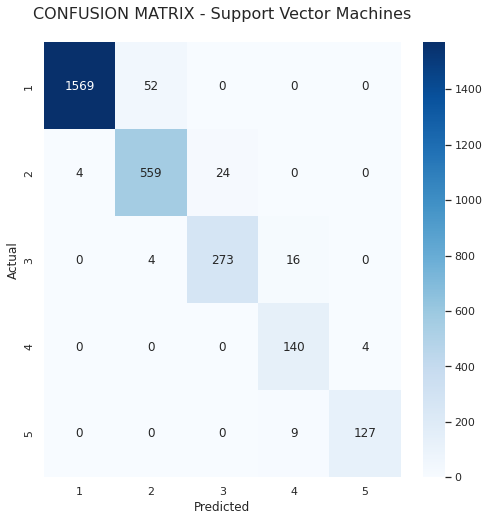

In [ ]:
svc = SVC(C = 50, kernel = 'linear')
svc.fit(X_undersampled, y_undersampled)
pred_y = svc.predict(scaled_val_x)
print('The precision using Support Vector Machine after hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Support Vector Machine after hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Support Vector Machine after hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Support Vector Machine after hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Support Vector Machines\n", size = 16);

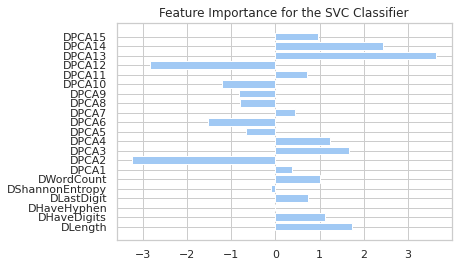

In [ ]:
plt.barh(train_x.columns[1:], svc.coef_[0][1:], align='center')
plt.title('Feature Importance for the SVC Classifier')
plt.show()

The precision using Decision Trees after hyperparameter tuning is 0.9985724062682684
The recall using Decision Trees after hyperparameter tuning is 0.998561668464581
The accuracy score using Decision Trees after hyperparameter tuning is 0.998561668464581
The F1 score using Decision Trees after hyperparameter tuning is 0.9985627856420672 



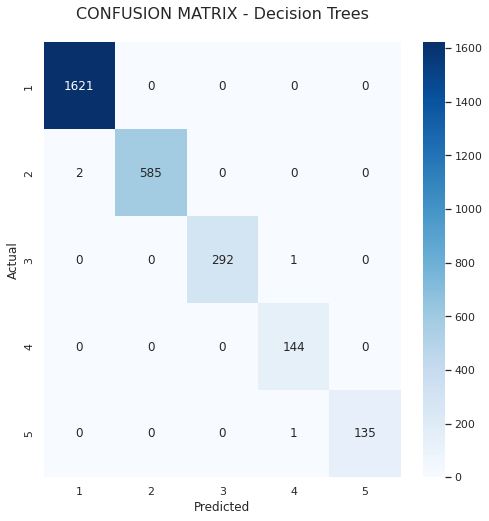

In [ ]:
dtc = DTC(criterion = 'gini', max_depth = 5, splitter = 'best')
dtc.fit(X_oversampled, y_oversampled)
pred_y = dtc.predict(scaled_val_x)
print('The precision using Decision Trees after hyperparameter tuning is', precision_score(val_y, pred_y, average = 'weighted'))
print('The recall using Decision Trees after hyperparameter tuning is', recall_score(val_y, pred_y, average = 'weighted'))
print('The accuracy score using Decision Trees after hyperparameter tuning is', accuracy_score(val_y, pred_y))
print('The F1 score using Decision Trees after hyperparameter tuning is', f1_score(val_y, pred_y, average = 'weighted'), '\n')
confusion_matrix(val_y, pred_y)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(val_y, pred_y), annot = True, cmap = "Blues", fmt = 'd', xticklabels = [1, 2, 3, 4, 5], yticklabels = [1, 2, 3, 4, 5])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Decision Trees\n", size = 16);

### **Discussion and Reflection**

Variance threshold is very useful in helping identify information gain in variables. However, a lesson learnt is that some variables e.g., binary, Boolean, have only a small range of values to begin with. This is especially demonstrated in the google vectors created using word2vec-google-news-300 which range between -1 and 1. The variance of which would always be between -1 and 1 as well. These would have been dropped if our variance threshold was too high. Other feature selection techniques such as sequential and recursive feature selection can be employed as next steps.

The logistic regression and support vector machine models were observed to identify that the ratio of digits in the domain name, the length of the domain name and the number of meaningful words in the domain name, were strong influencers of the value of the domain name.   

Some additional features such as the PageRank or GoogleRank identified in the review of previous works could not be used in this study as the domains in the dataset are not yet active. These can however be applied in other case scenarios for more information gain.

GridSearchCV was very crucial in reducing overfitting as well as underfitting as it not only performs an exhaustive search for the best parameters using each combination of hyperparameters, but it also uses the k-fold cross validation technique. Hyperparameter tuning using GridSearchCV however requires close attention to the hyperparameters paired in parameter grids. For example, for logistic regression, available solvers have limited compatibility with certain penalties pairings. As such, in this report the saga solver which is compatible with all three available penalties was used. Saga is also ideal for multiclassification problems and larger datasets like this study's with <=10,000 rows.

Feature decomposition of the google vectors using Principal Component Analysis (PCA) was necessary as using all 300 vectors in addition to other features extracted, would have increased the complexity and computation time of our models. However, decomposing the vectors from 300 to 15 may have led to loss of valuable information. Next steps would be to increase the number of features extracted using PCA from 15 to 50 and measure the impact of this on each model’s performance.  

To minimize overfitting, a 70/30 train validation split was used enabling the models to train on a significant portion of the existing data and give them a sizable proportion to make predictions on. Also, stratifying the data ensured that the random sample generated in the split returned the same distribution of target variable categories as is present in the full dataset.

In conclusion, the models were able to correctly identify > 86% of the target variables due to the information contained in the features extracted.  

As next steps, other classification algorithms can be explored to optimize prediction abilities. Ensemble algorithms such as GradientBoostClassifier and XGBoostClassifier would likely have done a better job of making predictions due to their inbuilt abilities to train multiple models and get the best results from these ensembles. Artificial neural networks would also be a great approach as they will likely make better predictions by way of their hidden layers.  